In [1]:
import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))

2024-04-30 01:02:58.013274: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-30 01:02:59.015466: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-04-30 01:03:00.374507: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-30 01:03:00.461192: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-30 01:03:00.461511: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [2]:




















import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [3]:
%load_ext tensorboard

In [4]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from pathlib import Path
import matplotlib.pyplot as plt
import pydot

In [5]:
# Set your data directory
data_dir = Path('leaf/').with_suffix('')

# Parameters
batch_size = 32
image_size = (150, 150)
num_classes = 15
epochs = 10

In [6]:
plant_labels = [
    "Ulmus carpinifolia",
    "Acer",
    "Salix aurita",
    "Quercus",
    "Alnus incana",
    "Betula pubescens",
    "Salix alba 'Sericea'",
    "Populus tremula",
    "Ulmus glabra",
    "Sorbus aucuparia",
    "Salix sinerea",
    "Populus",
    "Tilia",
    "Sorbus intermedia",
    "Fagus silvatica"
]
plant_labels = sorted(plant_labels)

In [7]:
# Data preprocessing and augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2)  # 20% validation split

# Load and preprocess data
train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    seed=42,
    classes=plant_labels
    )

validation_generator = datagen.flow_from_directory(
    data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    seed=42,
    classes=plant_labels
    )

Found 900 images belonging to 15 classes.
Found 225 images belonging to 15 classes.


In [8]:
inv_map = {v: k for k, v in train_generator.class_indices.items()}

In [9]:
inv_map

{0: 'Acer',
 1: 'Alnus incana',
 2: 'Betula pubescens',
 3: 'Fagus silvatica',
 4: 'Populus',
 5: 'Populus tremula',
 6: 'Quercus',
 7: "Salix alba 'Sericea'",
 8: 'Salix aurita',
 9: 'Salix sinerea',
 10: 'Sorbus aucuparia',
 11: 'Sorbus intermedia',
 12: 'Tilia',
 13: 'Ulmus carpinifolia',
 14: 'Ulmus glabra'}

In [10]:
train_generator.class_indices

{'Acer': 0,
 'Alnus incana': 1,
 'Betula pubescens': 2,
 'Fagus silvatica': 3,
 'Populus': 4,
 'Populus tremula': 5,
 'Quercus': 6,
 "Salix alba 'Sericea'": 7,
 'Salix aurita': 8,
 'Salix sinerea': 9,
 'Sorbus aucuparia': 10,
 'Sorbus intermedia': 11,
 'Tilia': 12,
 'Ulmus carpinifolia': 13,
 'Ulmus glabra': 14}

In [11]:

# Model creation
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(image_size[0], image_size[1], 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    # MaxPooling2D(pool_size=(2, 2)),
    # Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    # Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Model training
history = model.fit(train_generator, epochs=epochs, validation_data=validation_generator)

/home/lucypher/Desktop/forestry/.venv/lib64/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-04-30 01:03:00.817110: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-30 01:03:00.817343: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Docume

Epoch 1/10


/home/lucypher/Desktop/forestry/.venv/lib64/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1714431785.070791   19074 service.cc:145] XLA service 0x7f7918008c80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1714431785.070824   19074 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2024-04-30 01:03:05.096637: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-30 01:03:05.242843: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN

 1/29 ━━━━━━━━━━━━━━━━━━━━ 3:12 7s/step - accuracy: 0.0312 - loss: 2.6817

I0000 00:00:1714431788.465941   19074 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


29/29 ━━━━━━━━━━━━━━━━━━━━ 17s 367ms/step - accuracy: 0.1866 - loss: 4.1537 - val_accuracy: 0.5822 - val_loss: 1.3240
Epoch 2/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 11s 301ms/step - accuracy: 0.6311 - loss: 1.1618 - val_accuracy: 0.7200 - val_loss: 0.8000
Epoch 3/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 273ms/step - accuracy: 0.7445 - loss: 0.7845 - val_accuracy: 0.7600 - val_loss: 0.6825
Epoch 4/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 8s 230ms/step - accuracy: 0.7849 - loss: 0.6628 - val_accuracy: 0.8222 - val_loss: 0.5459
Epoch 5/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 241ms/step - accuracy: 0.8520 - loss: 0.5157 - val_accuracy: 0.8711 - val_loss: 0.3687
Epoch 6/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 286ms/step - accuracy: 0.8705 - loss: 0.4095 - val_accuracy: 0.9111 - val_loss: 0.3360
Epoch 7/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 11s 283ms/step - accuracy: 0.8678 - loss: 0.4000 - val_accuracy: 0.8978 - val_loss: 0.3046
Epoch 8/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 295ms/step - accuracy: 0.9018 - loss: 0.3331 - val_accuracy: 0.8889 

In [12]:
model.save('model_6.keras')

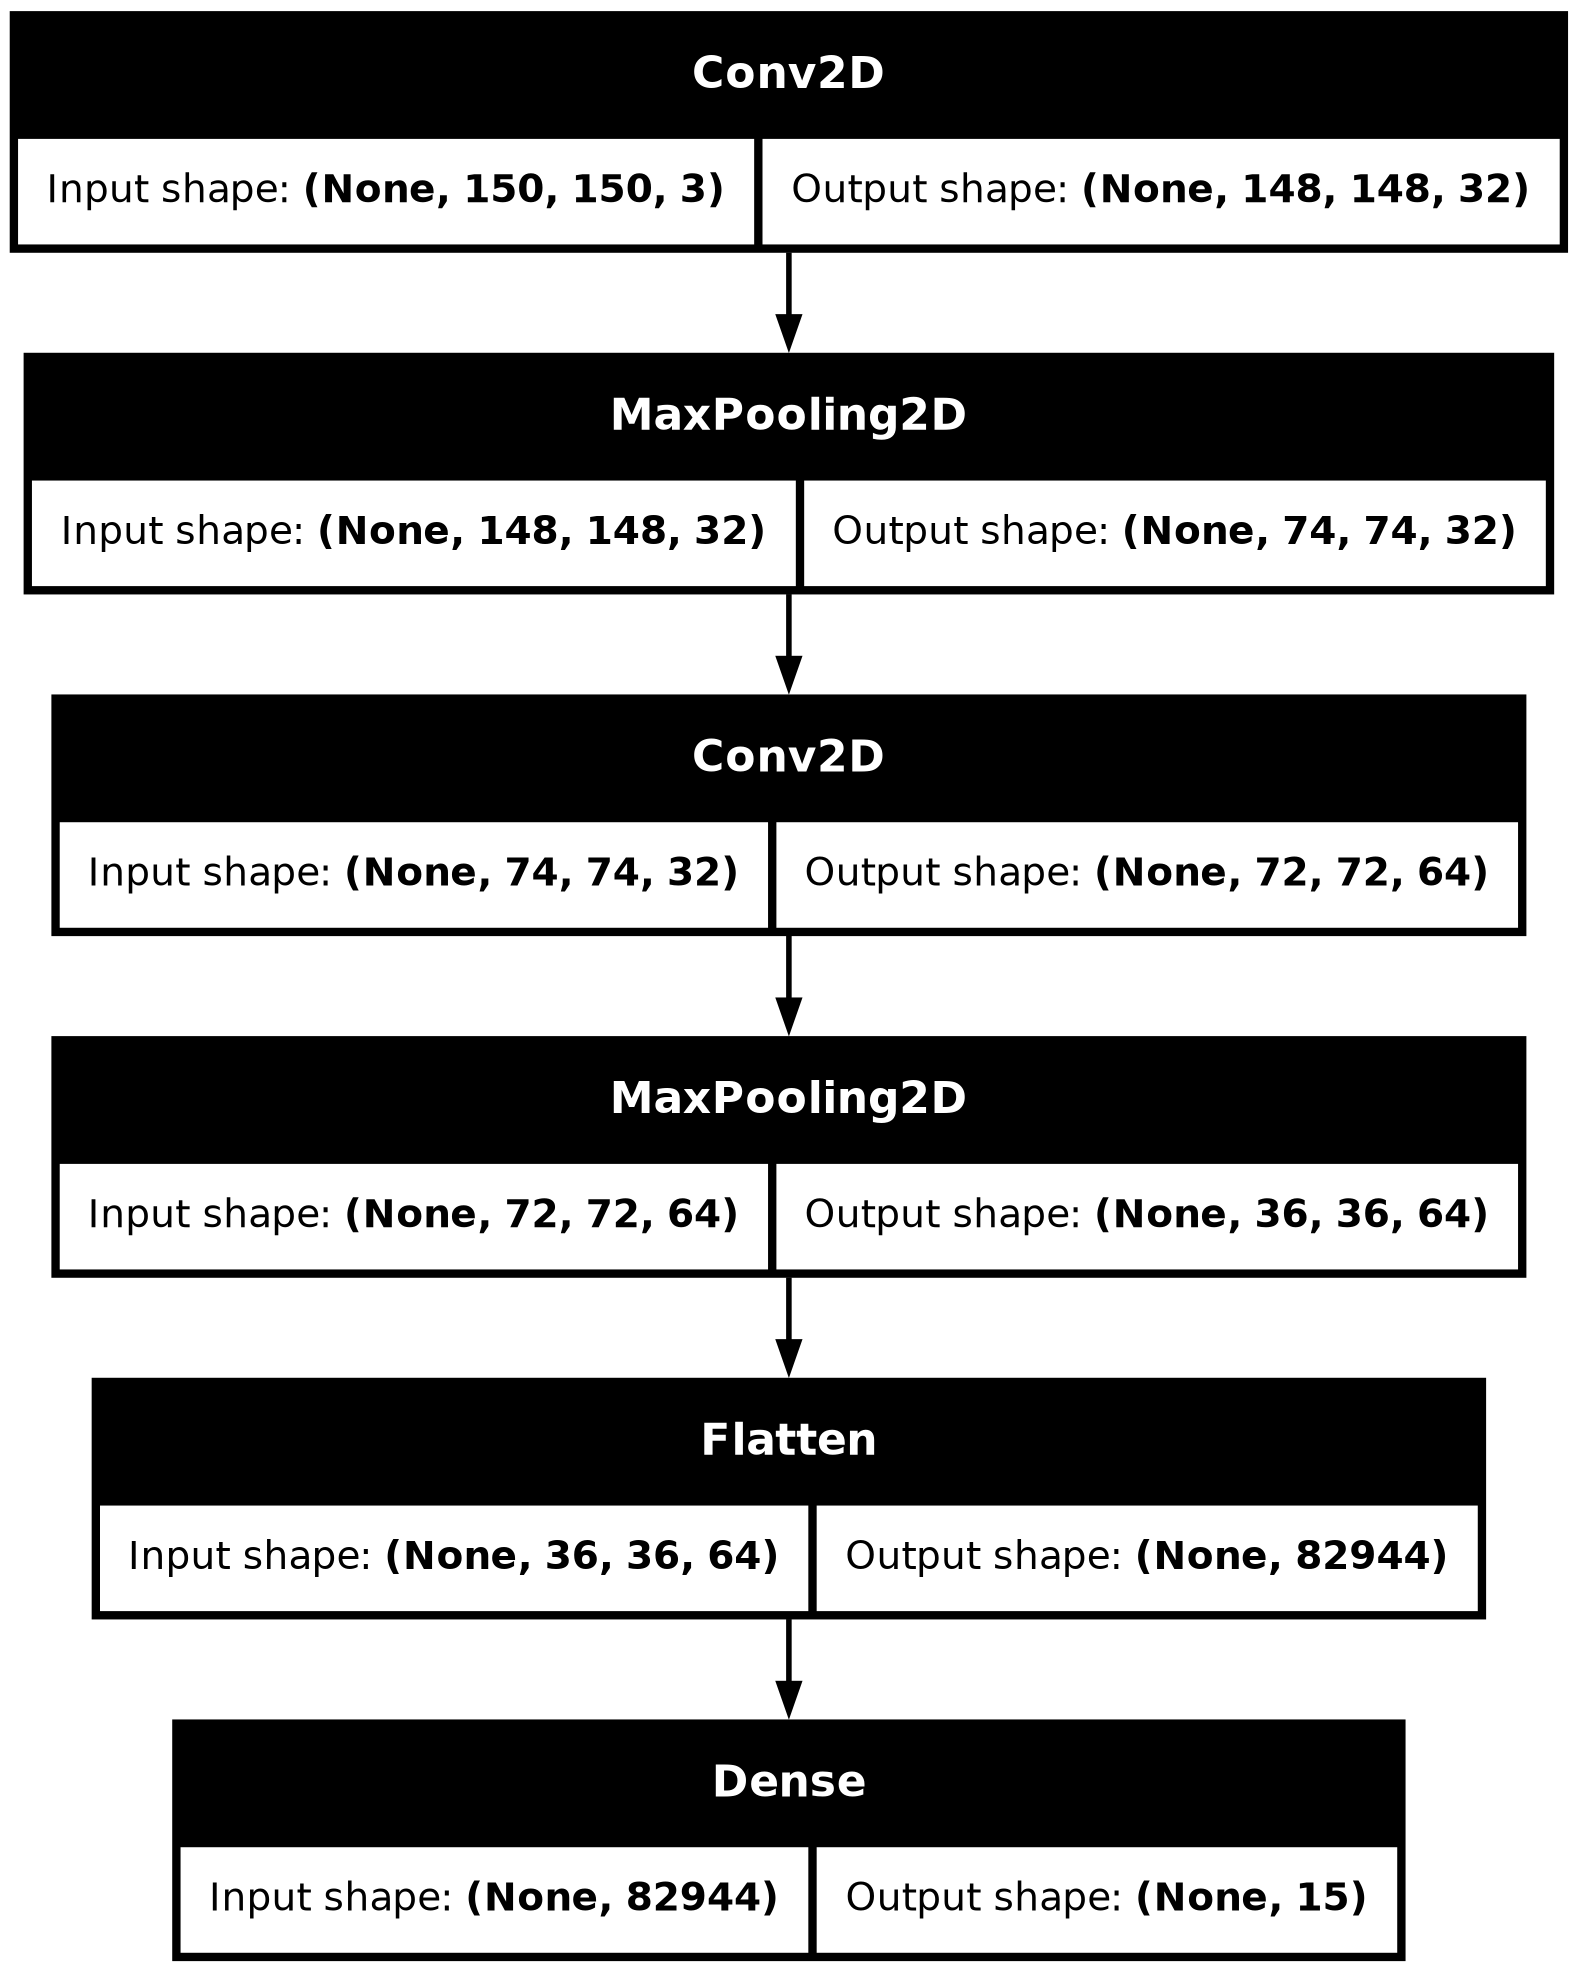

In [13]:
dot_img_file = 'model_6.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

In [14]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 82944)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 15)             │     1,244,175 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,790,703 (14.46 MB)

 Trainable params: 1,263,567 (4.82 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,527,136 (9.64 MB)

In [15]:
%matplotlib inline

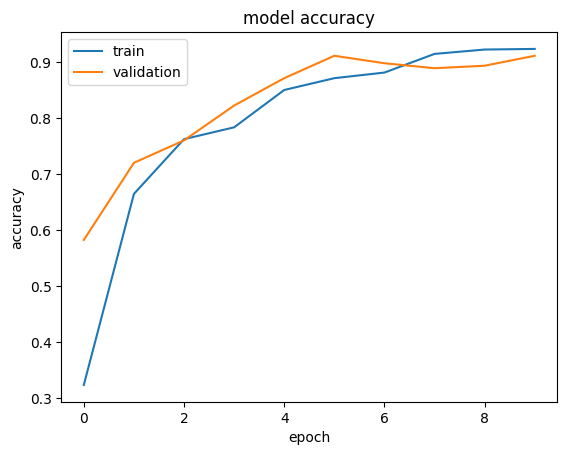

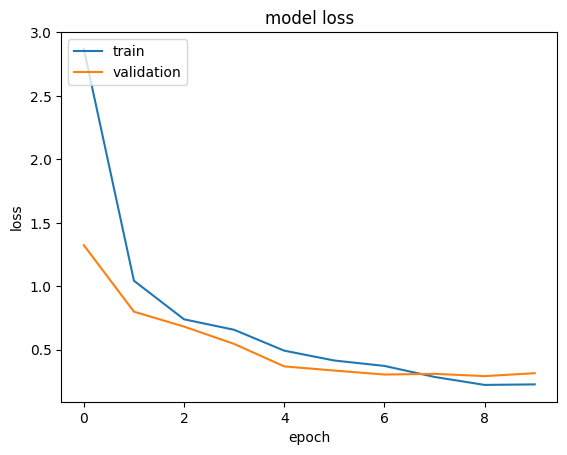

In [16]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [17]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

In [18]:
def preprocess_image(img_path, target_size=(150,150)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0  # Normalize the image
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array

In [19]:
test_image = preprocess_image('hahaha.jpg')
model.predict(test_image)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


array([[1.33874605e-03, 1.03969223e-05, 7.54888970e-06, 1.15995107e-07,
        2.93926238e-11, 1.23745878e-07, 1.35747061e-04, 1.48460595e-03,
        9.96556699e-01, 1.11003465e-04, 2.45516219e-07, 7.46251416e-08,
        3.02431924e-09, 3.54466931e-04, 1.36229545e-07]], dtype=float32)

In [20]:
idx = np.argmax(model.predict(test_image))
inv_map[idx]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


'Salix aurita'